# Customer Churn Analysis

---

Customer churn or customer attrition can broadly be classified as voluntary and involuntary churn. Voluntary churn is when the customer decides to cancel the service. In contrast, involuntary churn is when the customer is impacted by some external factor(s) and then stops using the service.

Differentiating the customers who churn and the customers who don't vary from domain to domain. For instance, not using the service during the last 30 days or not depositing money in an account during the previous three months can be considered churned customers. The reasons for churning also vary, and some common ones can be better prices, poor service, etc.

The best way to avoid customer churns is to know your customer. The best way to know your customer is to analyze historical data of customer behavior.

In this notebook, I will use a commercial bank's customer data to analyze customer behavior and model churning probability. Predicting the churning probability can be used as an early warning system to indicate customer's propensity to churn.

We can use two approaches to analyze customer data and model churn:

* **Classification**

* **Survival Analysis**


In ```Classification``` we use supervised machine learning algorithms to predict the probability of churn.

In ```Survival Analysis```, we estimate **average time-to-churn** among all customers. To do that, we use the **Kaplan-Meier** survival function and **Cox's Proportional Hazard** model.

## Features description

---

* **CustomerId** - Unique identifier of the customer


* **Surname** - The surname of the customer


* **CreditScore** - Credit bureau score. Estimate for customer solvency.


* **Geography** - Customer location or origin.


* **Gender** - Customer gender.


* **Age** - Age of the customer.


* **Tenure** - The number of years the cutomer has been a client of the bank.


* **Balance** - Residues on the customer accounts.


* **NumOfProducts** - The number of products the customer purchased in the bank


* **HasCrCard** - Whether or not the customer has a credit card. (0=No, 1=Yes)


* **IsActiveMember** - Whether or not the customer is active. (0=No, 1=Yes)


* **EstimatedSalary** - Estimated annual salary of the customer.


* **Exited** - Target variable. Indicates whether or not the customer left the bank. (0=No, 1=Yes)

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn')

### Read the data

In [2]:
data = pd.read_csv("data/churn_modeling.csv")

In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


We have 10,000 observation and 14 features. Among the 14 features one is target and first three features seems redundant which we have to remove.

In [4]:
data.shape

(10000, 14)

### Drop redundant columns

---

The columns ```RowNumber```, ```CustomerId```, and ```Surname``` do not carry any information useful for data analysis and churn prediction. Hence, we can drop them.

In [5]:
data = data.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [6]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Simple Descriptive Statistics

In [7]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Distribution of the target variable

---

Below we see that we have 20.37% churned customers and 79.63% of not churned customers. This can be indicator of imbalanced data or skewness. This may lead to false negatives. We will handle this issue in modeling part.

In [8]:
pd.DataFrame(data["Exited"].value_counts(normalize=True) * 100)

,Exited
0,79.63
1,20.37


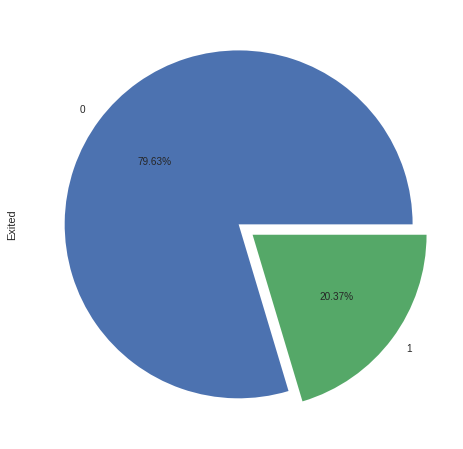

In [9]:
plt.figure(figsize=(10,8))

data['Exited'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.2f%%');

### Checking missing values, abnormalities, and outliers

We have no missing values

In [10]:
pd.DataFrame(data.isna().sum())

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


Checking some abnormal observations in features. To do so, I will use the ```value_counts()``` method to see how many unique values we have and if there are observations that should not be there. Alongside that, I will also check the summary statistics of each feature and plot some graphs.

The histogram of credit bureau score follows normal distribution with some extrem values chopped at the right tail.

In [11]:
pd.DataFrame(data['CreditScore'].describe().round(2))

,CreditScore
count,10000.00
mean,650.53
std,96.65
min,350.00
25%,584.00
50%,652.00
75%,718.00
max,850.00


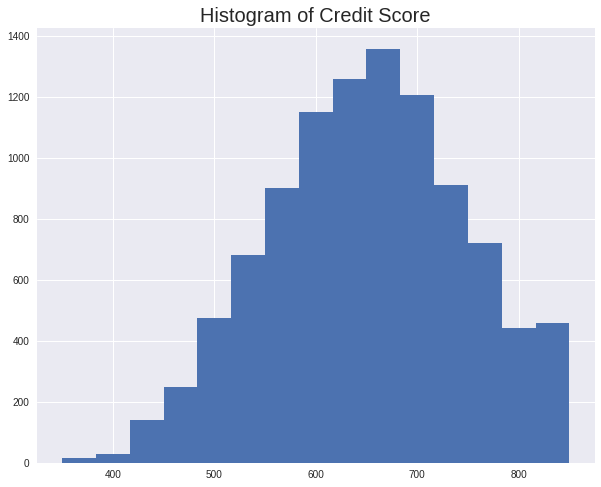

In [12]:
plt.figure(figsize=(10,8))

plt.hist(data["CreditScore"], bins=15)

plt.title("Histogram of Credit Score", fontsize=20);

Most of the customers are from France. The number of customers originating from Germany and Spain are almost equal.

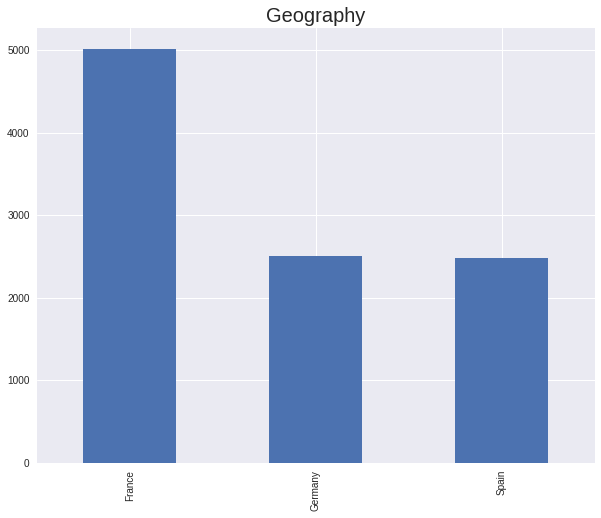

In [13]:
plt.figure(figsize=(10,8))

data["Geography"].value_counts(dropna=False).plot.bar()

plt.title("Geography", fontsize=20);

The gender is distributed almost equally across the observations and does not contain any abnormal observation.

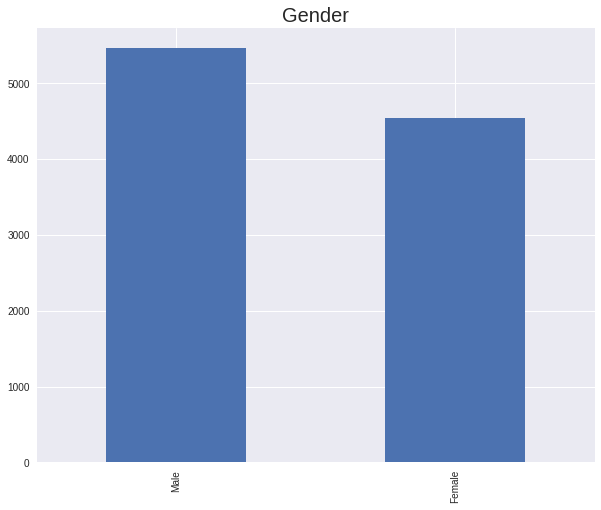

In [14]:
plt.figure(figsize=(10,8))

data["Gender"].value_counts(dropna=False).plot.bar()

plt.title("Gender", fontsize=20);

The distribution of the age variable looks normal. However, we see some extreme values at the right tail, which may turn out to be outliers.

In [15]:
pd.DataFrame(data['Age'].describe().round(2)).iloc[1:]

,Age
mean,38.92
std,10.49
min,18.00
25%,32.00
50%,37.00
75%,44.00
max,92.00


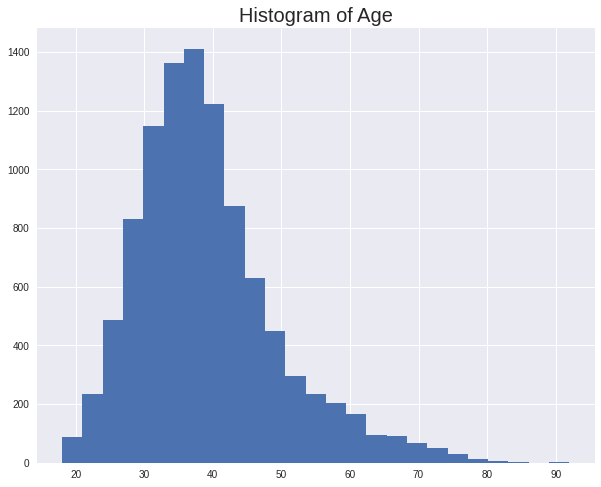

In [16]:
plt.figure(figsize=(10,8))

plt.hist(data["Age"], bins=25)

plt.title("Histogram of Age", fontsize=20);

The tenure variable histogram shows that most customers are the bank clients for at least one year and at most nine years.

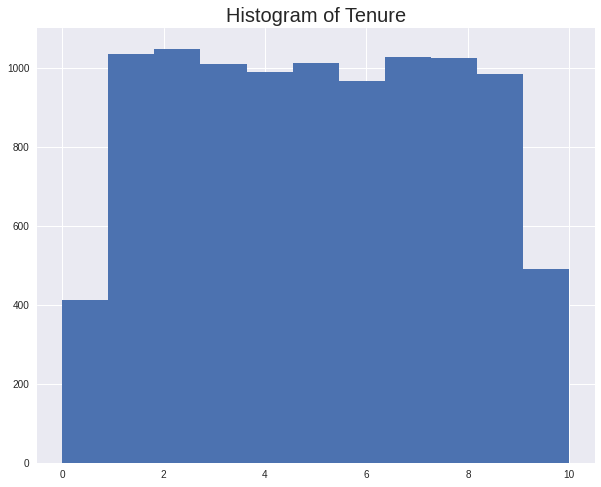

In [17]:
plt.figure(figsize=(10,8))

plt.hist(data["Tenure"], bins=11)

plt.title("Histogram of Tenure", fontsize=20);

There are few people whose balance is more than 200K and many customers whose balance is between zero and 40K.

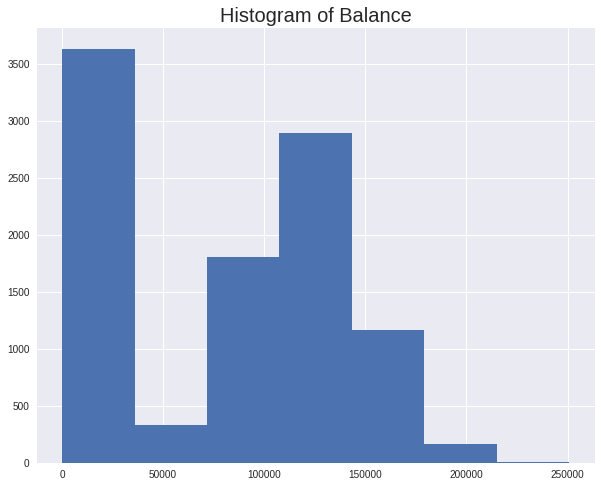

In [18]:
plt.figure(figsize=(10,8))

plt.hist(data["Balance"], bins=7)

plt.title("Histogram of Balance", fontsize=20);

The count plot of the number of products variable shows that most parts of customers own either one or two products.

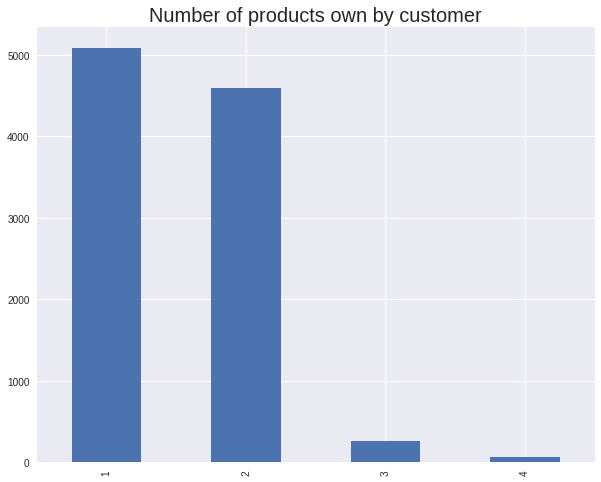

In [19]:
plt.figure(figsize=(10,8))

data["NumOfProducts"].value_counts().plot.bar()

plt.title("Number of products own by customer", fontsize=20);

### Outlier analysis

The boxplots show some possible outliers in ```Age``` and ```NumOfProducts``` variables. Let check if they are outside of the interquartile range to make sure we have real outliers.

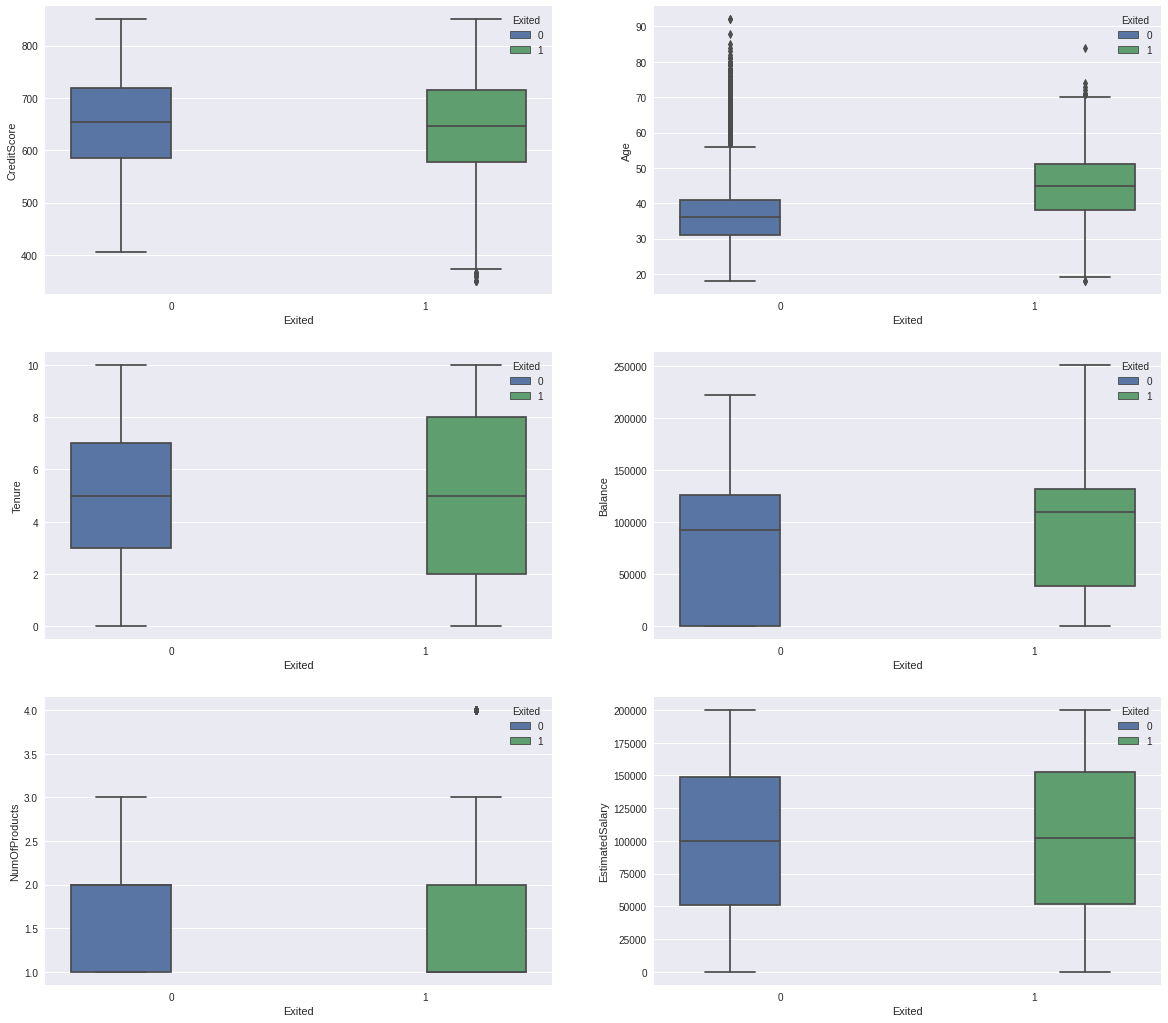

In [20]:
fig, axarr = plt.subplots(3, 2, figsize=(20, 18))

sns.boxplot(y='CreditScore', x='Exited', hue='Exited', data=data, ax=axarr[0][0])

sns.boxplot(y='Age', x='Exited', hue='Exited', data=data, ax=axarr[0][1])

sns.boxplot(y='Tenure',x='Exited', hue='Exited', data=data, ax=axarr[1][0])

sns.boxplot(y='Balance',x='Exited', hue='Exited', data=data, ax=axarr[1][1])

sns.boxplot(y='NumOfProducts', x='Exited', hue='Exited', data=data, ax=axarr[2][0])

sns.boxplot(y='EstimatedSalary',x='Exited', hue='Exited', data=data, ax=axarr[2][1]);

Checking each observation of ```Age``` and ```NumOfProducts``` against being outside of iterquartile range shows that we have some outliers.

In [22]:
for feature in data[['Age', "NumOfProducts"]]:
    
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower = Q1 - (1.5* IQR)
    upper = Q3 + (1.5 * IQR)
    
    if data[(data[feature] > upper)].any(axis=None):
        print(f"{feature} has outliers")
    else:
        print(f"{feature} does not have outliers")

Age has outliers
NumOfProducts has outliers


**Some notable points based on box plots**: 

---
* There is no significant difference in the credit score distribution between retained and churned customers.


* The older customers tend to churn more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups.


* With regard to the tenure, the clients on either extreme end (spent little time with the bank or a lot of time with the bank) are more likely to churn compared to those that are of average tenure.


* The bank is losing customers with significant bank balances which is likely to hit their available capital for lending.


* Neither the number of products nor the salary has a significant effect on the likelihood to churn.

## Bivariate Analysis

Let check if already churned customers have some balance left on their accounts. It turned out that 1,537 churned customers still have a non-zero balance. On average, they left $120,746. Pretty high amount to lose. This suggests that there may be some errors in the data.

In [23]:
data[(data["Exited"] == 1) & (data["Balance"] != 0.0)].shape[0]

1537

In [24]:
data[(data["Exited"] == 1) & (data["Balance"] != 0.0)]["Balance"].mean().round(2)

120746.97

### Let see each variable's influance on the target variable

In [25]:
bins = [0, 500, 600, 700, 800]

labels = ["low", "medium", "medium_high", "extreme_high"]

data["binned_score"] = pd.cut(data['CreditScore'], bins=bins, labels=labels)

The cross tabulation below shows that the customers who has medium and medium high credit score are more likely to churn.

In [26]:
pd.crosstab(index=data["binned_score"],
            columns=data["Exited"])

Exited,0,1
binned_score,,
low,491,152
medium,1910,513
medium_high,3065,753
extreme_high,1979,492


We see that 11.39% of female customers churn compared to 8.98% male customers.

In [27]:
pd.crosstab(index=data["Gender"],
            columns=data["Exited"],
            normalize=True) * 100

Exited,0,1
Gender,,
Female,34.04,11.39
Male,45.59,8.98


In univariate analysis we saw that the most parts of the customers originated from France. However, the churn is in France and in Germany are very close. This may indicate that the bank have some problems related to service or product in Germany.

In [28]:
pd.crosstab(index=data["Geography"],
            columns=data["Exited"])

Exited,0,1
Geography,,
France,4204,810
Germany,1695,814
Spain,2064,413


From the cross tabulation table we see that the bank loss customers between 30-60 age range. This suggests that the bank may not targeted the proper market by age or the bank does not have age tailored product for that age group.

In [29]:
bins = [0, 30, 45, 60, 92]

labels = ["young", "middle", "old", "elder"]

data["binned_age"] = pd.cut(data['Age'], bins=bins, labels=labels)

In [30]:
pd.crosstab(index=data["binned_age"],
            columns=data["Exited"])

Exited,0,1
binned_age,,
young,1820,148
middle,4989,932
old,805,842
elder,349,115


Having credit card, somewhat reduces the churn rate. We see that the customers who churned only 613 of them does not have credit cards.

In [31]:
pd.crosstab(index=data["HasCrCard"],
            columns=data["Exited"])

Exited,0,1
HasCrCard,,
0,2332,613
1,5631,1424


There is some obfuscation around the ```IsActiveMember``` variable. However, the relationship seems natural. While the customer is inactive, there is high tendency to churn that customer.

In [32]:
pd.crosstab(index=data["IsActiveMember"],
            columns=data["Exited"])

Exited,0,1
IsActiveMember,,
0,3547,1302
1,4416,735


The effect of tenure on churn rate is not so obvious. Here, we see the churn rate by gender and average tenure.On average tenure does not influance whether the cutomer leave or not. We have the same situation for the ```Balance``` and ```EstimatedSalary``` variable.

In [33]:
data.groupby(["Gender", "Exited"]).agg({"Tenure" : "mean"}).round(2)

Tenure
Gender Exited        
Female 0         4.98
       1         4.93
Male   0         5.08
       1         4.93

In [34]:
data.groupby(["Gender", "Exited"]).agg({"Balance" : "mean"}).round(2)

Balance
Gender Exited          
Female 0       71183.25
       1       89036.64
Male   0       73911.61
       1       93736.48

In [35]:
data.groupby(["Gender", "Exited"]).agg({"EstimatedSalary" : "mean"}).round(2)

EstimatedSalary
Gender Exited                 
Female 0              99816.07
       1             102948.99
Male   0              99680.39
       1              99584.29

#### Correlation Matrix

In [36]:
numerical_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

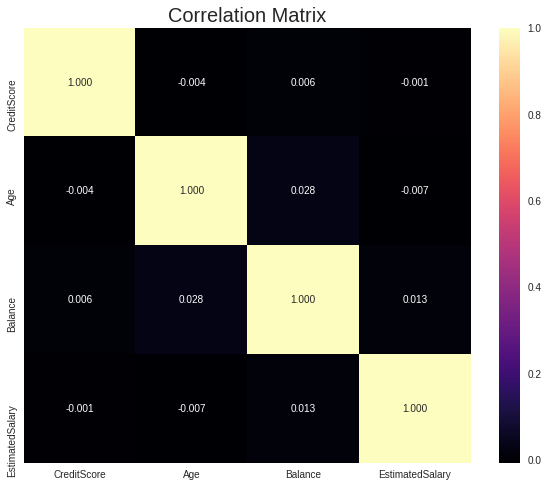

In [37]:
plt.figure(figsize=(10,8))

sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".3f", cmap="magma" )

plt.title("Correlation Matrix", fontsize=20);

# Feature Engineering

Let remove helper columns created for bivariate analysis.

In [38]:
data = data.drop(columns=["binned_score", "binned_age"])

In [39]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Derive some features which will help to predict customer churned or not.

First, the ratio between `Balance` and `EstimatedSalary` will give us the customer's balance as a share of annual salary. This can be considered as a proxy of customer propensity to save. If a customer holds a lot, then the churn for them has to be low.

In [43]:
data["Balance_over_Salary"] = data["Balance"] / data["EstimatedSalary"]

Considering the fact that `Tenure` is a function of `Age`, I introduce two new features. The fist is tenure divided by age, and the second is age minus tenure.

In [46]:
data["Tenure_over_Age"] = data["Tenure"] / data["Age"]

data["Age_Tenure"] = data["Age"] - data["Tenure"]

To account for credit behavior given age, I derive a new feature: `CreditScore` divided by `Age`.

In [53]:
data["CreditScore_over_Age"] = data["CreditScore"] / data["Age"]

### Correlation Matrix after adding derived features

In [57]:
numerical_features = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary",
                     "Balance_over_Salary", "Tenure_over_Age", "Age_Tenure", "CreditScore_over_Age"]

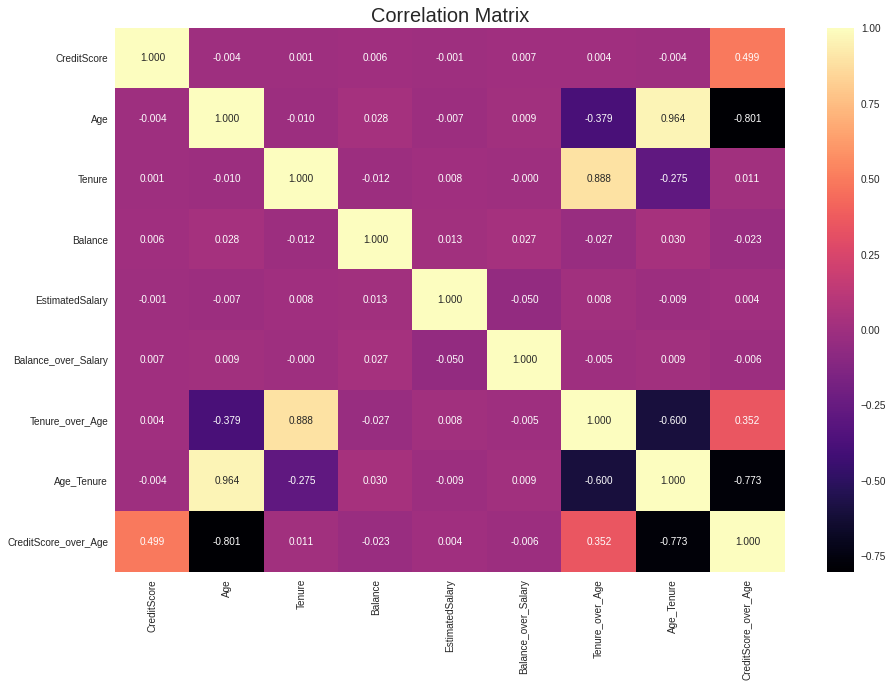

In [60]:
plt.figure(figsize=(15,10))

sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".3f", cmap="magma" )

plt.title("Correlation Matrix", fontsize=20);

Export data into CSV file for modeling.

In [62]:
data.to_csv("data.csv", index=False)

# Future Research

### Uplift modeling instead of churn prediction

---

[Why you should stop predicting customer churn and start using uplift models](https://www.sciencedirect.com/science/article/pii/S0020025519312022)

[Uplift Modeling in Python](https://github.com/duketemon/pyuplift)

[scikit-uplift](https://pypi.org/project/scikit-uplift/)

[CausalLift](https://medium.com/@Minyus86/causallift-python-package-for-uplift-modeling-in-real-world-business-e60264812a26)

[Uplift Modeling & QINI Curve with Python](https://www.kaggle.com/davinwijaya/uplift-modeling-qini-curve-with-python)

[Pylift](https://tech.wayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling/)

[Uplift Modeling: A Quick Introduction](https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0)